<a href="https://colab.research.google.com/github/krits29/regeneron-house-waste/blob/main/regeneron_house_waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('regeneron-house-waste')
jovian.set_colab_id('17GG0OShLzQycPgbwwRcEOjGCWc-vV6Lr')

     |████████████████████████████████| 68 kB 4.5 MB/s 


# regeneron-house-waste

Use the "Run" button to execute the code.

In [1]:
!pip install jovian --upgrade --quiet

     |████████████████████████████████| 68 kB 4.6 MB/s 


In [2]:
import jovian

In [4]:
# Execute this to save new versions of the notebook
jovian.commit(project="regeneron-house-waste")

[jovian] Detected Colab notebook...


[jovian] Error: jovian.commit doesn't work on Colab unless the notebook was created and executed from Jovian.
Make sure to run the first code cell at the top after executing from Jovian.
Alternatively, you can download this notebook and upload it manually to Jovian.
Learn more: https://jovian.ai/docs/user-guide/run.html#run-on-colab


In [5]:
# Using 'opendatasets' and download https://www.kaggle.com/mostafaabla/garbage-classification

In [6]:
!pip install opendatasets --upgrade --quiet

In [7]:
import opendatasets as od

In [8]:
dataset_url = "https://www.kaggle.com/mostafaabla/garbage-classification"

In [9]:
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: krits29
Your Kaggle Key: ··········


  9%|▉         | 21.0M/239M [00:00<00:01, 215MB/s]

100%|██████████| 239M/239M [00:00<00:00, 278MB/s]


In [10]:
# import dataset into pytorch

In [11]:
data_dir = "./garbage-classification/garbage_classification"

In [12]:
import os

In [13]:
os.listdir(data_dir)

['green-glass',
 'plastic',
 'shoes',
 'metal',
 'battery',
 'white-glass',
 'paper',
 'biological',
 'brown-glass',
 'trash',
 'cardboard',
 'clothes']

In [14]:
# use ImageFolder class from torchvision

In [15]:
from torchvision.datasets import ImageFolder

In [16]:
dataset = ImageFolder(data_dir)

In [17]:
len(dataset)

15515

In [18]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=280x180 at 0x7F848AF34910>, 0)

In [19]:
dataset.classes

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

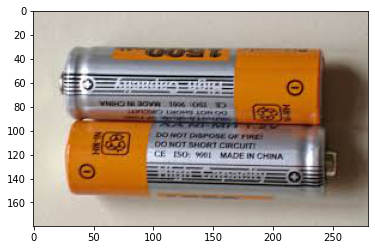

In [24]:
img, label = dataset[0]
plt.imshow(img)

In [26]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(224), tt.RandomCrop(224), tt.ToTensor()]))

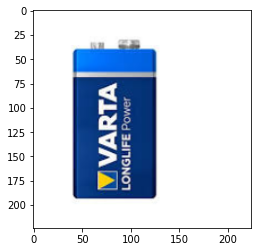

In [28]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [29]:
# split dataset into validation and trainig dataset

In [31]:
val_percentage = 0.1
val_size = int(val_percentage * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(13964, 1551)

In [32]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(13964, 1551)

In [ ]:
batch_size = 256